In [87]:
# class RobotabilityGraph that inherits from Graph class 
import os
import sys 
sys.path.append("/share/ju/urban-fingerprinting")

import osmnx as ox 
import geopandas as gpd 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
# enable latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from glob import glob 
from tqdm import tqdm 

from shapely import wkt, LineString 

import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show 


from src.utils.logger import setup_logger 

logger = setup_logger('robotability-score')
logger.setLevel("INFO")
logger.info("Modules initialized.")

WGS='EPSG:4326'
PROJ='EPSG:2263'



2024-12-10 01:41:47 - robotability-score - INFO - Modules initialized.


In [88]:
def min_max_normalize(series: pd.Series) -> pd.Series:
    """
    Normalize the input pandas Series using min-max normalization.

    Parameters:
    series (pd.Series): The pandas Series to normalize.

    Returns:
    pd.Series: A new pandas Series with values normalized between 0 and 1.
    """
    min_val = series.min()
    max_val = series.max()
    
    if min_val == max_val:
        # Avoid division by zero; if all values are the same, return 0 for all elements
        return pd.Series([0.0] * len(series), index=series.index)
    
    return (series - min_val) / (max_val - min_val)

In [89]:
dataset = pd.read_csv("../data/processed/score_dataset.csv", engine='pyarrow')
dataset = gpd.GeoDataFrame(dataset, geometry=dataset['geometry'].apply(wkt.loads), crs=PROJ)

In [90]:
len(dataset.index)

1876414

In [91]:
dataset.columns.values

array(['', '5g_technology', '5g_mindown', '5g_minup', '5g_environmnt',
       '5g_h3_res9_id', '4g_technology', '4g_mindown', '4g_minup',
       '4g_environmnt', '4g_h3_res9_id', 'width', 'segment_index',
       'geometry', 'point_index', 'ft_above_sea', 'n_cameras_median',
       'Unnamed: 0', 'width_street_furniture',
       'geometry_street_furniture', 'bus_stop_count', 'trash_can_count',
       'linknyc_count', 'citybench_count',
       'bicycle_parking_shelter_count', 'bicycle_rack_count',
       'tree_count', 'newsstand_count', 'parking_meter_count',
       'hydrant_count', 'street_sign_count', 'alarm_call_box_count',
       'scaffolding_permit_count', 'clutter', 'ZONEDIST', 'Shape_Leng',
       'Shape_Area', 'distance_to_nearest_station', 'CURBRAMP_count',
       'RAISEDCROSSWALK_count', 'boro_cd', 'shape_area', 'shape_leng',
       'cd_code', 'sidewalk_quality', 'POI_the_geom', 'POI_SEGMENTID',
       'POI_COMPLEXID', 'POI_SAFTYPE', 'POI_SOS', 'POI_PLACEID',
       'POI_FACI_DO

In [92]:
dataset.isna().sum()  

                                       0
5g_technology                       1635
5g_mindown                          1635
5g_minup                            1635
5g_environmnt                       1635
                                    ... 
sip_corridors_count                 1806
barnes_intersections_count          1806
leading_ped_intervals_count         1806
highest_bike_lane_facility_class    1806
num_peds_involved_in_collision      1806
Length: 73, dtype: int64

In [93]:
FEATURES = { 
    'sidewalk_width': 'Sidewalk Width',
    'pedestrian_density': 'Pedestrian Density',
    'street_furniture_density': 'Density of Street Furniture',
    'sidewalk_roughness': 'Sidewalk Roughness',
    'surface_condition': 'Surface Condition',
    'communication_infrastructure': 'Wireless Communication Infrastructure',
    'slope_gradient': 'Slope Gradient',
    'charging_station_proximity': 'Proximity to Charging Stations',
    'local_attitudes': 'Local Attitudes Towards Robots',
    'curb_ramp_availability': 'Curb Ramp Availability',
    'weather_conditions': 'Weather Conditions',
    'crowd_dynamics': 'Crowd Dynamics',
    'traffic_management': 'Traffic Management Systems',
    'surveillance_coverage': 'Surveillance Coverage',
    'zoning_laws': 'Zoning Laws and Regulation',
    'bike_lane_availability': 'Bike Lane Availability',
    'street_lighting': 'Street Lighting',
    'shade_availability': 'Existence of Shade',
    'gps_signal_strength': 'GPS Signal Strength',
    'pedestrian_flow': 'Pedestrian Flow',
    'bicycle_traffic': 'Bicycle Traffic',
    'vehicle_traffic': 'Vehicle Traffic',
    'digital_map_existence': 'Existence of Detailed Digital Maps',
    'intersection_safety': 'Intersection Safety'
}



In [94]:
len(FEATURES)

24

In [95]:
# which 

In [96]:
# read csv as dict and store in WEIGHTS 
WEIGHTS = pd.read_csv("../survey_processing/feature_weights.csv", index_col=0).to_dict()['Weight']
WEIGHTS

{'pedestrian_density': 0.1471252405027565,
 'crowd_dynamics': 0.0947553411301599,
 'surface_condition': 0.0920027152241102,
 'sidewalk_width': 0.0786335724717843,
 'street_furniture_density': 0.0764198497958928,
 'intersection_safety': 0.065720170561695,
 'curb_ramp_availability': 0.0595744759623967,
 'communication_infrastructure': 0.0538902663892606,
 'digital_map_existence': 0.0476565441445884,
 'gps_signal_strength': 0.0411253178231809,
 'vehicle_traffic': 0.0378336513460469,
 'sidewalk_roughness': 0.037665272828114,
 'slope_gradient': 0.0367854938300333,
 'traffic_management': 0.0341575238351119,
 'zoning_laws': 0.0307599055298729,
 'bicycle_traffic': 0.020275434308962,
 'charging_station_proximity': 0.018202827081173,
 'surveillance_coverage': 0.0144243034834116,
 'bike_lane_availability': 0.0129920937514483}

In [97]:
# get sum of weights 
sum(WEIGHTS.values())

0.9999999999999993

In [98]:
features = pd.DataFrame()

In [99]:
# add geometry to features
features['geometry'] = dataset['geometry']
# add point index to features 
features['point_index'] = dataset['point_index']

### Sidewalk Width 

In [100]:
def PREPROCESS_sidewalk_width(col): 
    # softmax the sidewalk width so that it is between 0 and 1
    col = min_max_normalize(col)

    return col

dataset['sidewalk_width'] = PREPROCESS_sidewalk_width(dataset['width'])

In [101]:
def COMPUTE_sidewalk_width(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['sidewalk_width']


In [102]:
features['sidewalk_width'] = COMPUTE_sidewalk_width(dataset['sidewalk_width'])

### Pedestrian Density 

In [103]:
def PREPROCESS_pedestrian_density(col):
    # softmax the pedestrian density so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['pedestrian_density'] = PREPROCESS_pedestrian_density(dataset['TRAFFIC_Pedestrian'])

In [104]:
def COMPUTE_pedestrian_density(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['pedestrian_density']

In [105]:
features['pedestrian_density'] = COMPUTE_pedestrian_density(dataset['pedestrian_density'])

### Street Furniture Density 

In [106]:
def PREPROCESS_street_furniture_density(col):
    # softmax the street furniture density so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['street_furniture_density'] = PREPROCESS_street_furniture_density(dataset['clutter'])

In [107]:
def COMPUTE_street_furniture_density(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['street_furniture_density']

features['street_furniture_density'] = COMPUTE_street_furniture_density(dataset['street_furniture_density'])

### Sidewalk Roughness 

In [108]:
# SKIP preprocessing, as all values are already 1

In [109]:
def COMPUTE_sidewalk_roughness(col=None, WEIGHTS=WEIGHTS): 
    return 1 * WEIGHTS['sidewalk_roughness']


In [110]:
features['sidewalk_roughness'] = COMPUTE_sidewalk_roughness()

# check out accessmap for this 

### Surface Condition 

In [111]:
def PREPROCESS_surface_condition(col):
    col = min_max_normalize(col)
    col = col.fillna(col.mean())
    return col

dataset['surface_condition'] = PREPROCESS_surface_condition(dataset['sidewalk_quality'])

In [112]:
def COMPUTE_surface_condition(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['surface_condition']

features['surface_condition'] = COMPUTE_surface_condition(dataset['surface_condition'])

### Wireless Communication Infrastructure 

In [113]:
# SKIP preprocessing, as all values are already 0 or 1

In [114]:
def COMPUTE_communication_infrastructure(row, WEIGHTS=WEIGHTS): 
    return (1 if (row['4g_minup'] > 0 and row['4g_mindown'] > 0) else 0) * WEIGHTS['communication_infrastructure']

In [115]:
features['communication_infrastructure'] = dataset.apply(lambda row: COMPUTE_communication_infrastructure(row), axis=1)

### Slope Gradient 

In [116]:
from scipy.spatial import cKDTree
import numpy as np
from tqdm import tqdm

def POPULATE_slope_gradient_optimized_with_progress(dataset, WEIGHTS=WEIGHTS):
    # Convert geometries to numpy arrays for faster distance computation
    coords = np.array([[geom.x, geom.y] for geom in dataset['geometry']])
    tree = cKDTree(coords)

    # Initialize an array for slope gradients
    slope_gradients = np.zeros(len(dataset))

    # Precompute distances for each point
    for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
        # Get indices of nearest neighbors within 50 units, excluding the point itself
        distances, indices = tree.query(coords[i], k=10, distance_upper_bound=50)
        
        # Remove invalid indices (those equal to len(coords))
        valid_mask = (indices != len(coords)) & (indices != i)
        valid_indices = indices[valid_mask]
        valid_distances = distances[valid_mask]
        
        # Compute slope gradients
        if len(valid_indices) > 0:
            height_diffs = np.abs(dataset['ft_above_sea'].iloc[valid_indices] - row['ft_above_sea'])
            slopes = height_diffs / valid_distances
            # take absolute value of slope
            slopes = np.abs(slopes)
            slope_gradients[i] = slopes.mean() * WEIGHTS['slope_gradient']

    return slope_gradients

# Apply the optimized function with progress monitoring
dataset['slope_gradient'] = POPULATE_slope_gradient_optimized_with_progress(dataset)

# take the absolute value of the slope

100%|██████████| 1876414/1876414 [12:20<00:00, 2535.02it/s]


In [117]:
def POSTPROCESS_slope_gradient(col): 
    # softmax the slope gradient so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['slope_gradient'] = POSTPROCESS_slope_gradient(dataset['slope_gradient'])

In [118]:
def COMPUTE_slope_gradient(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['slope_gradient']


In [119]:
features['slope_gradient'] = COMPUTE_slope_gradient(dataset['slope_gradient'])

<Axes: >

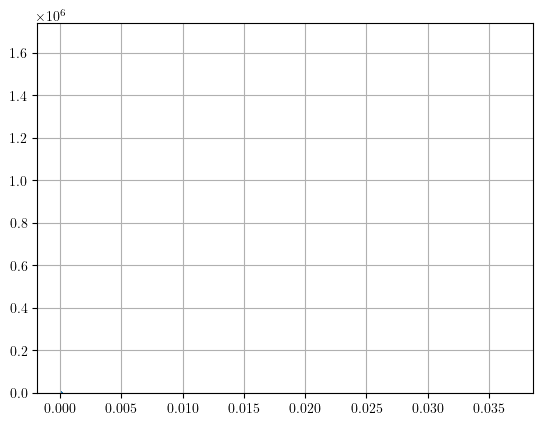

In [120]:
# log the distribution here, as this one might be tricky 
features['slope_gradient'].hist(bins=1000)

### Charging Station Proximity 

In [121]:
# convert to col-level function 
def POPULATE_charging_station_proximity(col, RANGE=max(dataset['distance_to_nearest_station'])): 
    return (RANGE-col)/RANGE

In [122]:
dataset['charging_station_proximity'] = POPULATE_charging_station_proximity(dataset['distance_to_nearest_station'])

In [123]:
def POSTPROCESS_charging_station_proximity(col):
    # softmax the charging station proximity so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['charging_station_proximity'] = POSTPROCESS_charging_station_proximity(dataset['charging_station_proximity'])

In [124]:
def COMPUTE_charging_station_proximity(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['charging_station_proximity']

features['charging_station_proximity'] = COMPUTE_charging_station_proximity(dataset['charging_station_proximity'])

### Local Attitudes Towards Robots 

**SKIP DUE TO LACK OF DATA** 

### Curb Ramp Availability 

In [125]:
def PREPROCESS_curb_ramp_availability(col): 
    col = min_max_normalize(col)
    return col

dataset['curb_ramp_availability'] = PREPROCESS_curb_ramp_availability(dataset['CURBRAMP_count'])

In [126]:
def COMPUTE_curb_ramp_availability(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['curb_ramp_availability']

features['curb_ramp_availability'] = COMPUTE_curb_ramp_availability(dataset['curb_ramp_availability'])

### Weather Conditions 

** Skip due to hyperlocal/temporal nature of weather conditions ** 

### Crowd Dynamics 

In [127]:
def zonedist_to_indicator(row): 
    
    if row:

        if row.startswith('M'): 
            return 10
        elif row.startswith('R'):
            return 5
        elif row.startswith('C'): 
            return 0
        else: 
            return 2 
    else:
        return 0


def POPULATE_crowd_dynamics(col): 
    return col.apply(zonedist_to_indicator)

dataset['crowd_dynamics'] = POPULATE_crowd_dynamics(dataset['ZONEDIST'])

In [128]:
def POSTPROCESS_crowd_dynamics(col):
    # softmax the crowd dynamics so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['crowd_dynamics'] = POSTPROCESS_crowd_dynamics(dataset['crowd_dynamics'])

In [129]:
def COMPUTE_crowd_dynamics(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['crowd_dynamics']

features['crowd_dynamics'] = COMPUTE_crowd_dynamics(dataset['crowd_dynamics'])

### Traffic Management 

In [130]:
def POPULATE_traffic_management(df, WEIGHTS=WEIGHTS): 
    return  (df['in_slow_zone'] + df['turn_traffic_calming_count'] + df['sip_intersections_count'] + df['sip_corridors_count'] + df['barnes_intersections_count'] + df['leading_ped_intervals_count']).fillna(0)

dataset['traffic_management'] = POPULATE_traffic_management(dataset)





In [131]:
def POSTPROCESS_traffic_management(col): 
    # softmax the traffic management so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['traffic_management'] = POSTPROCESS_traffic_management(dataset['traffic_management'])
    

In [132]:
def COMPUTE_traffic_management(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['traffic_management']

features['traffic_management'] = COMPUTE_traffic_management(dataset['traffic_management'])


### Surveillance Coverage 

In [133]:
def PREPROCESS_surveillance_coverage(col): 
    # softmax the surveillance coverage so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['surveillance_coverage'] = PREPROCESS_surveillance_coverage(dataset['n_cameras_median'])

In [134]:
def COMPUTE_surveillance_coverage(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['surveillance_coverage']

features['surveillance_coverage'] = COMPUTE_surveillance_coverage(dataset['surveillance_coverage'])
    

### Zoning Laws & Regulations

In [135]:
def PREPROCESS_zoning_laws(col): 
    # softmax the zoning laws so that it is between 0 and 1
    col = min_max_normalize(col)
    col = col.fillna(0)
    return col

dataset['zoning_laws'] = PREPROCESS_zoning_laws(dataset['avg_speed_limit'])



In [136]:
def COMPUTE_zoning_laws(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['zoning_laws']

features['zoning_laws'] = COMPUTE_zoning_laws(dataset['zoning_laws'])

### Bike Lane Availability 

In [137]:
def PREPROCESS_bike_lane_availability(col):
    # softmax the bike lane availability so that it is between 0 and 1
    col = min_max_normalize(col)
    col = col.fillna(0)
    return col

dataset['bike_lane_availability'] = PREPROCESS_bike_lane_availability(dataset['highest_bike_lane_facility_class'])

In [138]:
def COMPUTE_bike_lane_availability(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['bike_lane_availability']

features['bike_lane_availability'] = COMPUTE_bike_lane_availability(dataset['bike_lane_availability'])


### Street Lighting

** Skip due to lack of data ** 

### Shade Availability 

**Come Back**

### GPS Signal Strength

In [139]:
# SKIP preprocessing, as all values are already 0 or 1

In [140]:
def COMPUTE_gps_signal_strenth(col=None, WEIGHTS=WEIGHTS): 
    return 1 * WEIGHTS['gps_signal_strength']

features['gps_signal_strength'] = COMPUTE_gps_signal_strenth()

### Pedestrian Flow 

** Skip due to lack of data ** 

### Bicycle Traffic 

In [141]:
def PREPROCESS_bicycle_traffic(col):
    # softmax the bicycle traffic so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['bicycle_traffic'] = PREPROCESS_bicycle_traffic(dataset['TRAFFIC_Bike'])


In [142]:
def COMPUTE_bicycle_traffic(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['bicycle_traffic']

features['bicycle_traffic'] = COMPUTE_bicycle_traffic(dataset['bicycle_traffic'])

### Vehicle Traffic 

In [143]:
def PREPROCESS_vehicle_traffic(col):
    # softmax the vehicle traffic so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['vehicle_traffic'] = PREPROCESS_vehicle_traffic(dataset['TRAFFIC_Car'])


In [144]:
def COMPUTE_vehicle_traffic(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['vehicle_traffic']

features['vehicle_traffic'] = COMPUTE_vehicle_traffic(dataset['vehicle_traffic'])

### Existence of Detailed Digital Map 

In [145]:
def COMPUTE_ddm():
    return 1 * WEIGHTS['digital_map_existence']

In [146]:
features['digital_map_existence'] = COMPUTE_ddm()

### Intersection Safety 

In [147]:
def PREPROCESS_intersection_safety(col):
    # softmax the intersection safety so that it is between 0 and 1
    col = col.fillna(0).astype(int)
    col = min_max_normalize(col)
    return col

dataset['intersection_safety'] = PREPROCESS_intersection_safety(dataset['num_peds_involved_in_collision'])

In [148]:
def COMPUTE_intersection_safety(col, WEIGHTS=WEIGHTS):

    return col * WEIGHTS['intersection_safety']

features['intersection_safety'] = COMPUTE_intersection_safety(dataset['intersection_safety'])

## SANITY CHECKS

In [149]:
# assert that all values of all columns except geometry and pouint_index are 0-1
for col in features.columns: 
    if col not in ['geometry', 'point_index']: 
        assert features[col].min() >= 0 and features[col].max() <= 1

In [150]:
features.isna().sum() 

geometry                             0
point_index                          0
sidewalk_width                       0
pedestrian_density              311083
street_furniture_density             0
sidewalk_roughness                   0
surface_condition                    0
communication_infrastructure         0
slope_gradient                      76
charging_station_proximity           0
curb_ramp_availability               0
crowd_dynamics                       0
traffic_management                   0
surveillance_coverage                0
zoning_laws                          0
bike_lane_availability               0
gps_signal_strength                  0
bicycle_traffic                 311083
vehicle_traffic                 311083
digital_map_existence                0
intersection_safety                  0
dtype: int64

In [151]:
len(features.columns)

21

In [152]:
# which FEATURES aren't a column in features? 
print(set(FEATURES.keys()) - set(features.columns))


{'street_lighting', 'pedestrian_flow', 'shade_availability', 'local_attitudes', 'weather_conditions'}


In [153]:
POLARITIES = { 
    'sidewalk_width': 1,
    'pedestrian_density': -1,
    'street_furniture_density': -1, 
    'sidewalk_roughness': -1,
    'surface_condition': 1,
    'communication_infrastructure': 1,
    'slope_gradient': -1,
    'charging_station_proximity': 1,
    'local_attitudes': 1,
    'curb_ramp_availability': 1,
    'weather_conditions': 1,
    'crowd_dynamics': 1,
    'traffic_management': 1,
    'surveillance_coverage': 1,
    'zoning_laws': 1,
    'bike_lane_availability': 1,
    'street_lighting': 1,
    'shade_availability': 1,
    'gps_signal_strength': 1,
    'pedestrian_flow': -1,
    'bicycle_traffic': -1,
    'vehicle_traffic': -1,
    'digital_map_existence': 1,
    # num incidents, so more is worse
    'intersection_safety': -1,
}

In [154]:
# score is the aggregation of all features 
features['score'] = features.drop(columns=['geometry', 'point_index']).mul(pd.Series(POLARITIES)).sum(axis=1)



In [155]:
features.describe([0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99, 0.999]) 

,point_index,sidewalk_width,pedestrian_density,street_furniture_density,sidewalk_roughness,surface_condition,communication_infrastructure,slope_gradient,charging_station_proximity,curb_ramp_availability,...,traffic_management,surveillance_coverage,zoning_laws,bike_lane_availability,gps_signal_strength,bicycle_traffic,vehicle_traffic,digital_map_existence,intersection_safety,score
count,1.876414e+06,1.876414e+06,1.565331e+06,1.876414e+06,1.876414e+06,1.876414e+06,1.876414e+06,1.876338e+06,1.876414e+06,1.876414e+06,...,1.876414e+06,1.876414e+06,1.876414e+06,1.876414e+06,1.876414e+06,1.565331e+06,1.565331e+06,1.876414e+06,1.876414e+06,1.876414e+06
mean,9.370853e+05,4.750542e-03,5.915096e-03,5.335556e-03,3.766527e-02,8.433687e-02,5.375339e-02,1.834842e-05,1.514418e-02,1.265195e-03,...,6.210853e-04,6.698173e-04,1.264958e-02,1.306564e-03,4.112532e-02,1.124581e-04,1.156220e-02,4.765654e-02,1.130306e-04,2.511029e-01
std,5.410661e+05,2.806522e-03,9.726379e-03,1.178124e-02,1.804113e-16,1.077850e-02,2.712507e-03,5.471776e-05,3.500254e-03,4.623085e-03,...,1.466965e-03,1.431154e-03,6.017194e-03,3.254066e-03,0.000000e+00,3.271985e-04,4.096021e-03,2.775558e-17,7.725731e-04,2.998769e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.766527e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.112532e-02,0.000000e+00,0.000000e+00,4.765654e-02,0.000000e+00,9.285569e-03
0.1%,1.876413e+03,5.653732e-04,0.000000e+00,0.000000e+00,3.766527e-02,0.000000e+00,0.000000e+00,0.000000e+00,5.192639e-04,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.112532e-02,0.000000e+00,0.000000e+00,4.765654e-02,0.000000e+00,1.037685e-01
1%,1.876013e+04,1.081451e-03,0.000000e+00,0.000000e+00,3.766527e-02,3.682249e-02,5.389027e-02,0.000000e+00,3.993549e-03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.112532e-02,0.000000e+00,1.644941e-03,4.765654e-02,0.000000e+00,1.535904e-01
2.5%,4.690333e+04,1.475240e-03,0.000000e+00,0.000000e+00,3.766527e-02,6.550979e-02,5.389027e-02,0.000000e+00,6.288659e-03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.112532e-02,0.000000e+00,3.289883e-03,4.765654e-02,0.000000e+00,1.749036e-01
5%,9.380665e+04,1.858331e-03,0.000000e+00,0.000000e+00,3.766527e-02,6.930978e-02,5.389027e-02,0.000000e+00,8.231748e-03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.112532e-02,0.000000e+00,4.402916e-03,4.765654e-02,0.000000e+00,1.940413e-01
10%,1.875483e+05,2.342113e-03,0.000000e+00,0.000000e+00,3.766527e-02,7.375203e-02,5.389027e-02,0.000000e+00,1.005912e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.112532e-02,0.000000e+00,6.031452e-03,4.765654e-02,0.000000e+00,2.136999e-01
25%,4.686312e+05,3.217896e-03,5.162289e-04,0.000000e+00,3.766527e-02,8.196752e-02,5.389027e-02,4.518872e-06,1.329245e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,1.537995e-02,0.000000e+00,4.112532e-02,0.000000e+00,8.819264e-03,4.765654e-02,0.000000e+00,2.411871e-01


In [156]:
features['segment_index'] = dataset['segment_index']
features[['point_index','segment_index','geometry','score']].to_csv("../data/processed/score_nyc.csv")

In [157]:
features.to_csv("../data/processed/robotability_features.csv", index=False)